In [81]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
import os
from copy import deepcopy

In [82]:
plt.style.use(['science'])
plt.rcParams['text.usetex'] = False
TOSAVE = False
plt.rcParams.update({'figure.dpi': '600'})

In [83]:
def read_log(path):
    out = dict()
    with open(path, 'r') as f:
        lines = f.read().splitlines()

    args = dict()
    df = pd.DataFrame(columns=['epoch', 'batch', 'time', 'time_0', 'data', 'data_0', 'Xent', 'Xent_0', 'Htri', 'Htri_0', 'Acc', 'Acc_0'])
    results = dict()

    for line in lines:
        if line.startswith('Experiment time'):
            out['time'] = line[16:]
        elif line.startswith('Args'):
            #Args:Namespace
            l = line[15:-1]
            l = l.split(', ')
            i=0
            while i < len(l):
                arg = l[i]
                if arg.startswith('stepsize'):
                    arg += ', ' + l[i+1]
                    k,v = arg.split('=')
                    args[k] = v
                    i+=1
                else:
                    k,v = arg.split('=')
                    args[k] = v
                i+=1
        elif line.startswith('Epoch:'):
            d = []
            ll = line.split('\t')
            for l in ll:
                l = l.split(' ')
                if l==['']:
                    pass
                elif l[0] == 'Epoch:':
                    a = l[1].index(']')
                    d.append(int(l[1][1:a]))
                    d.append(l[1][a+1:])
                else:
                    d.append(float(l[1]))
                    d.append(float(l[2][1:-1]))
            df.loc[len(df)] = d
        elif line.startswith('mAP:'):
            l = line.split(' ')
            results['mAP'] = float(l[1][:-1])
        elif line.startswith('Rank'):
            l = line.split(' ')
            name = l[0]
            results[name] = float(l[-1][:-1])

    to_p = ''
    for k,v in results.items():
        to_p += str(v) + ' '
    results['print'] = to_p
    out['args'] = args
    out['df'] = df
    out['results'] = results
            
    return out 

In [84]:
def myplot(y, x=None, xlabel='Step', ylabel='Acc', window=1):
    fig, ax = plt.subplots()
    plt.figure(figsize=(20, 10))
    if x is None:
        x = list(range(len(y)))
    x = np.array(x)
    y = np.array(y)

    # sliding average
    x = x[window-1:]
    y = np.convolve(y, np.ones(window), 'valid') / window

    plt.plot(x, y)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = plt.gca()
    plt.text(0.93, 1.05, '$w =$ '+str(window), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=8)
    plt.show()

In [85]:
def read_logs(path, type='Acc'):
    paths = os.listdir(path)
    paths = [p for p in paths if not p.startswith('.')]
    new_paths = []
    out2 = []
    for p in paths:
        out2.append(p)
        new_paths.append(os.path.join(path, p))
    new_paths = [n + '/log_train.txt' for n in new_paths]
    out = np.zeros(shape=(len(read_log(new_paths[0])['df'][type]), len(new_paths)))
    for i, p in enumerate(new_paths):
        read = read_log(p)
        df = read['df'][type]
        out[:,i] = df
    return out, out2

def myplots(data, labels, ylabel='Acc', window=1, ylim=None):
    #fig, ax = plt.subplots()
    plt.figure(figsize=(6, 4))

    x = list(range(len(data[:,0])))
    x = np.array(x)

    for i in range(data.shape[1]):
        y = data[:,i]
        y = np.array(y)
        # sliding average
        x_other = x[window-1:]

        y = np.convolve(y, np.ones(window), 'valid') / window

        plt.plot(x_other, y)

    plt.xlabel('Step')
    ylabel = ylabel + ' (w = ' + str(window) + ')'
    plt.ylabel(ylabel)
    plt.legend(labels)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlim([window, len(x)])

    for i in range(1, 10):
        # write "Epoch" every 59 steps
        plt.axvline(i*59, color='black', linestyle='--', alpha=0.1)
        plt.text(i*59+window, ylim[1]+1.3, 'Epoch '+str(i+1), horizontalalignment='center', verticalalignment='center', fontsize=5.5, alpha=0.4)

    ax = plt.gca()
    #plt.text(0.93, 1.05, '$w =$ '+str(window), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes, fontsize=8)
    plt.show()

In [86]:
out, labels = read_logs('logs/section1')
print(labels)

['mobilenet_v3_small-veri', 'vit_b_16-veri', 'resnet34-veri', 'resnet34_fc512-veri', 'resnet50_fc512-veri', 'resnet50-veri']


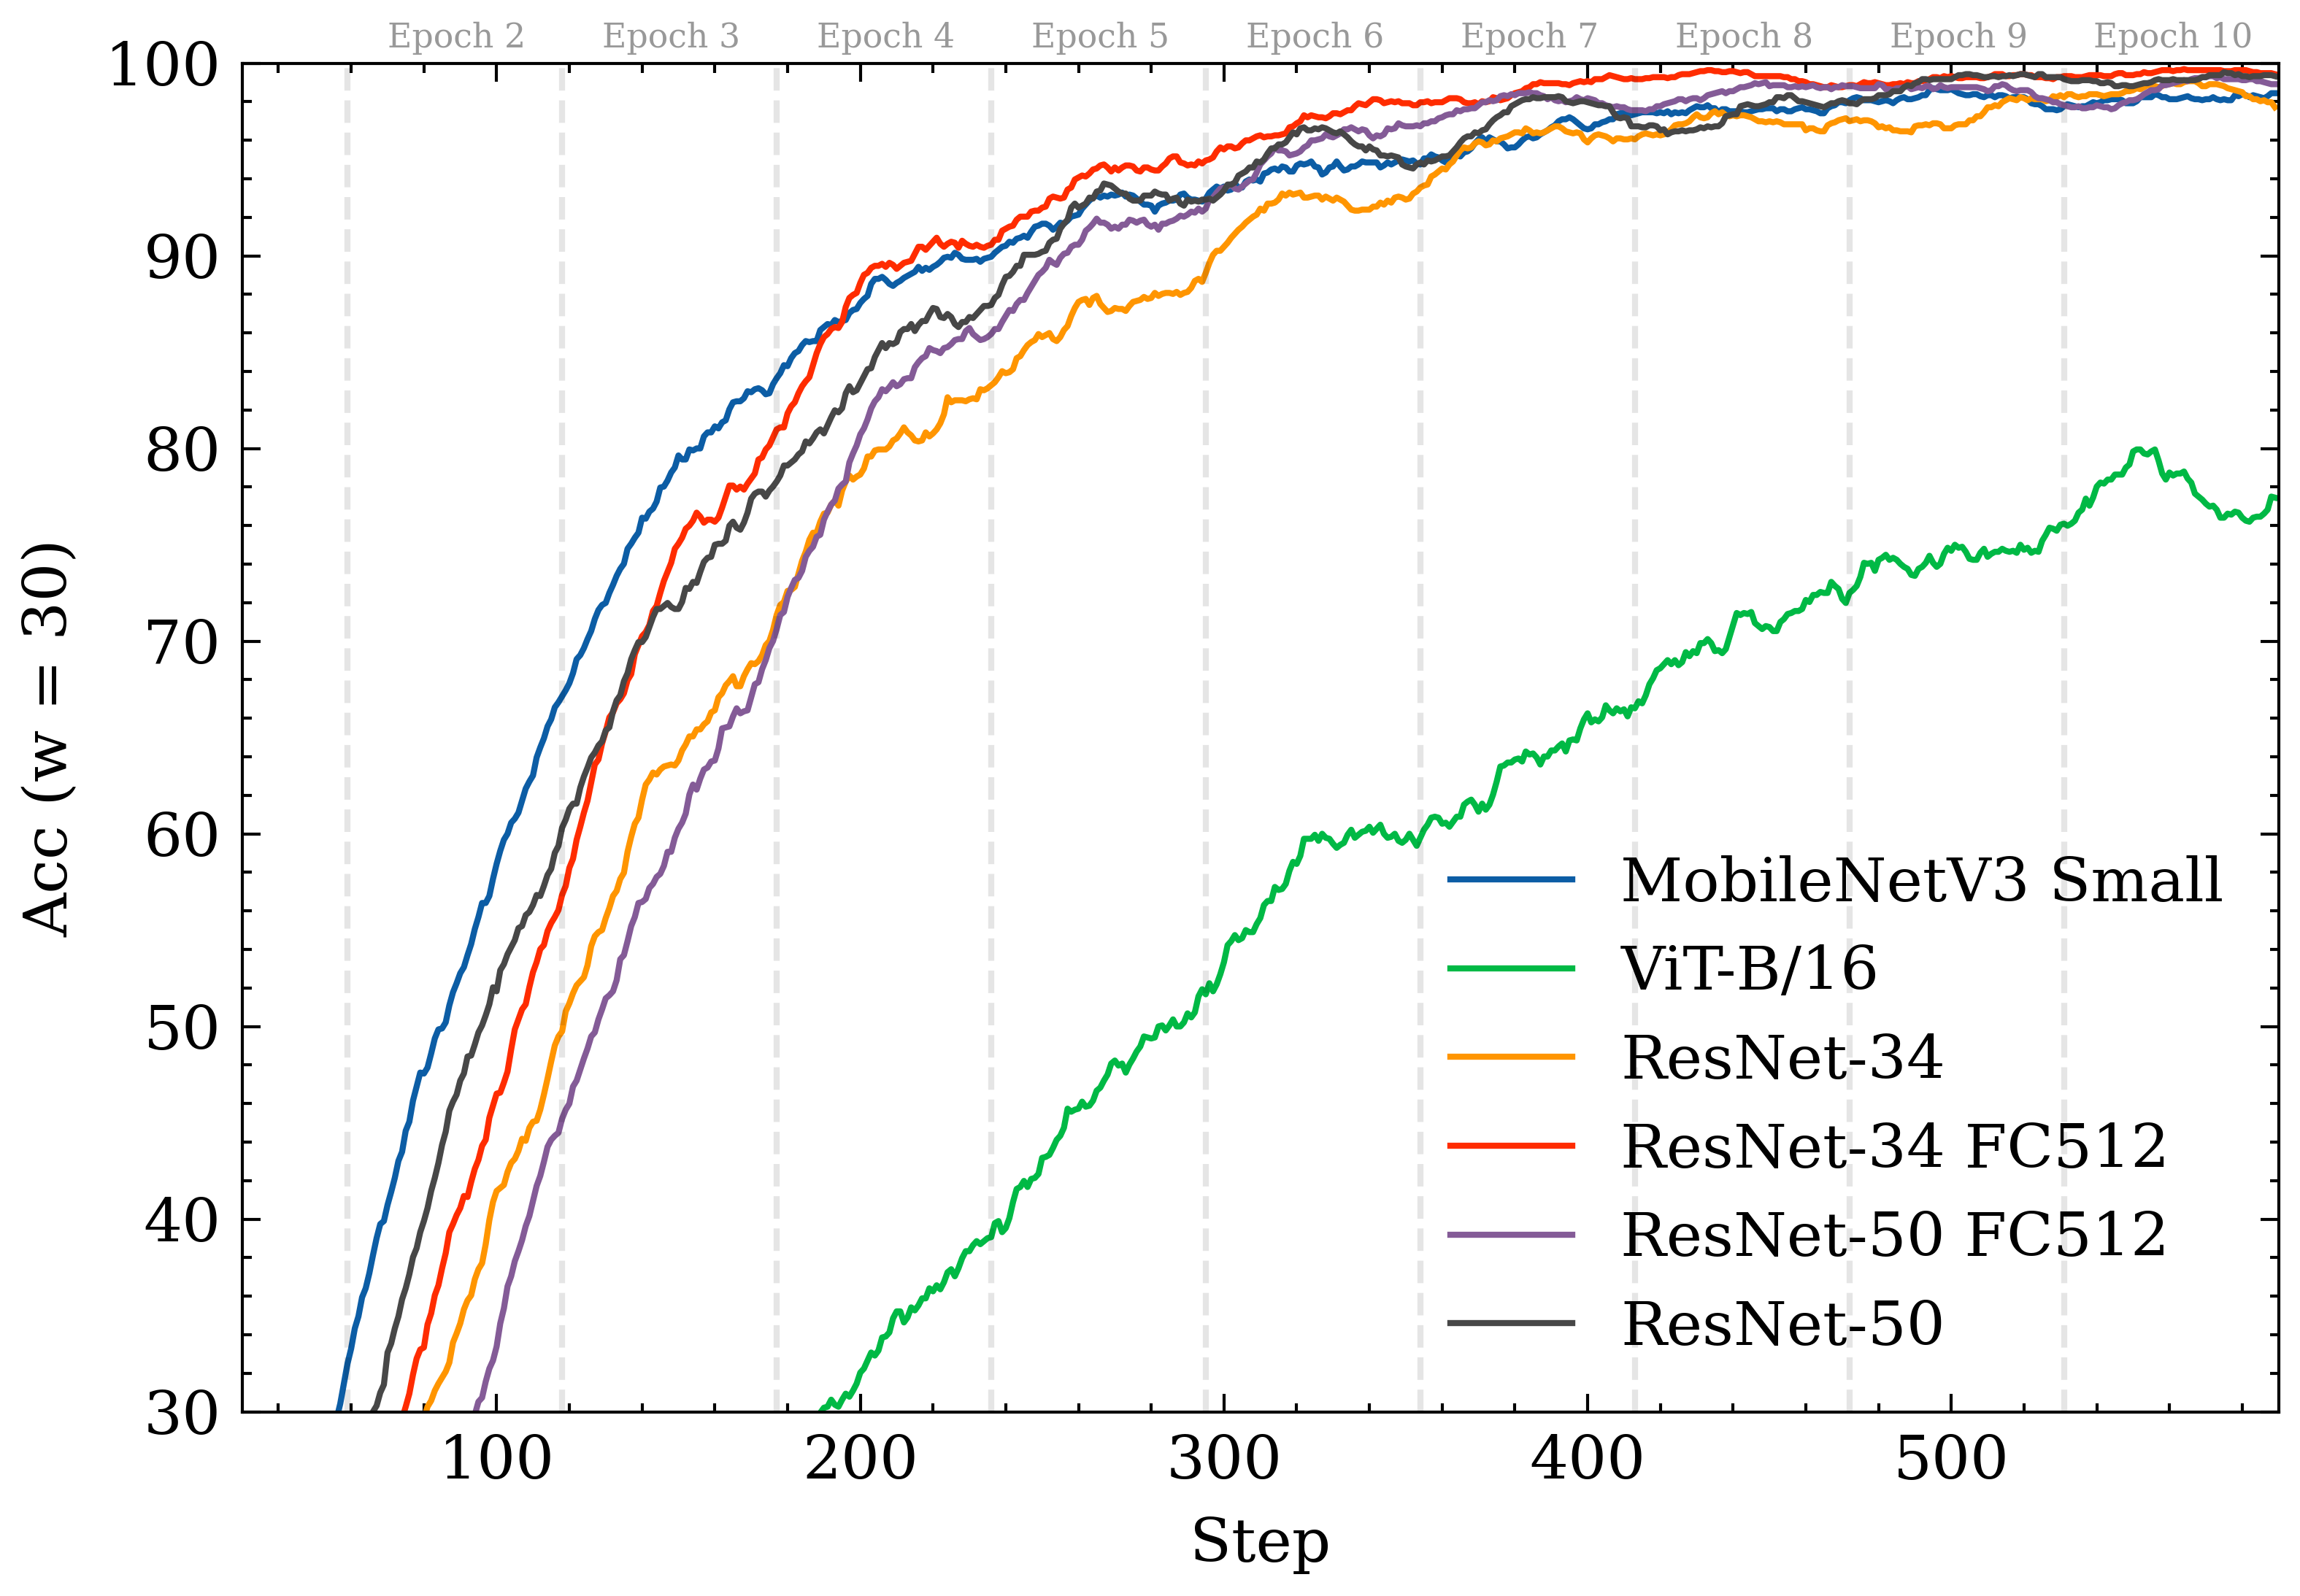

In [87]:
# ['mobilenet_v3_small-veri', 'vit_b_16-veri', 'resnet34-veri', 'resnet34_fc512-veri', 'resnet50_fc512-veri', 'resnet50-veri']
labels = ['MobileNetV3 Small', 'ViT-B/16', 'ResNet-34', 'ResNet-34 FC512', 'ResNet-50 FC512', 'ResNet-50']
myplots(out,labels, window=30, ylim = [30, 100])

In [88]:
out = read_log('logs/section1/resnet50_fc512-veri/log_train.txt')
out['results']['print']

'48.3 84.3 92.7 95.1 97.4 '